# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run! 

Note: This is required only when running in Udacity workspace. If you are running on your desktop, you do not need to run it.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

Note: If you are running on your local desktop. You need to change the `file_name` variable to the folder that contains the expected environment (i.e., `Tennis`).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])                

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


### 4. Training Agent with DDPG

In this section, we train two DDPG-based agents that will learn and play with each other. We note that this is a collaborative game as the objective of the both players is to scores as high as possible. It is unlike tic-tac-toe game where one player wins the game, the other player will loose the game, in this tennis game both players by somehow to maximize the score withouth reducing the score of other player. The neural networks for Actor and Critic are defined in file `model.py`. The DDPG-based agent is implemented in file `agent.py`.  Excluding the input and output layers, the neural networks for Actor and Critic have 3 hidden layers with (256, 128, 64) hidden nodes, respectively. As the game involves 2 players (i.e., specified by the number of agents in the environment), the DDPG-based agent will be implemented with the multi-agent approach in which the two agents (players) will learn from each other to achieve a beter performance along the game. Run the cell below to import neccessary libraries and Agent class. 

In [6]:
import torch
from collections import deque
import matplotlib.pyplot as plt

from agent import Agent

agent = Agent(state_size, action_size, num_agents, random_seed=42)           

In the cell below, we implement the DDPG with multi-agent version to train 2 players and play the game.  

In [7]:
def ma_ddpg(nb_episodes=5000, max_steps=1000):
    """Train the two players with the DDPG algorithm
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    
    scores_all = [] # store all max score value among two players for each episode
    scores_deque = deque(maxlen=100) # recent 100 max score value
    
    for i in range(nb_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        # get states and combine them, each player has 24 variables in its state vector
        # combining both state vector provides a 48-element vector of environment state
        states = env_info.vector_observations  
        agent.reset()
        episode_scores = np.zeros(num_agents)
        
        for t in range(max_steps):
            actions = agent.act(states)                    # the two agents select an action
            
            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                     # get status of the episode
            agent.step(states, actions, rewards, next_states, dones) # take a step (including learning)
            episode_scores += np.max(rewards)              # update the score (take the max of the two rewards)
            states = next_states                           # roll over the state to next time step
            
            if np.any(dones):                               # exit loop if episode finished
                break
        
        scores_deque.append(np.max(episode_scores))                # save most recent score to compute the average
        scores_all.append(np.max(episode_scores))                  # save score of the episode for plotting purpose  
        
        if i%100 == 0:
            print('\rEpisode {}\tMax Score: {:.2f}\tAverage Score: {:.2f}'.format(i, np.max(episode_scores), np.mean(scores_deque)))
        
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} Episodes \tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores_all


Run the cell below to train the agents and plot the reward after solving the environment.

Episode 0	Max Score: 0.00	Average Score: 0.00
Episode 100	Max Score: 0.00	Average Score: 0.00
Episode 200	Max Score: 0.00	Average Score: 0.00
Episode 300	Max Score: 0.00	Average Score: 0.01
Episode 400	Max Score: 0.00	Average Score: 0.01
Episode 500	Max Score: 0.00	Average Score: 0.00
Episode 600	Max Score: 0.00	Average Score: 0.00
Episode 700	Max Score: 0.00	Average Score: 0.02
Episode 800	Max Score: 0.00	Average Score: 0.01
Episode 900	Max Score: 0.00	Average Score: 0.05
Episode 1000	Max Score: 0.00	Average Score: 0.06
Episode 1100	Max Score: 0.10	Average Score: 0.10
Episode 1200	Max Score: 0.40	Average Score: 0.09
Episode 1300	Max Score: 0.10	Average Score: 0.10
Episode 1400	Max Score: 0.10	Average Score: 0.13
Episode 1500	Max Score: 0.30	Average Score: 0.17
Episode 1600	Max Score: 0.20	Average Score: 0.26

Environment solved in 1686 Episodes 	Average Score: 0.52


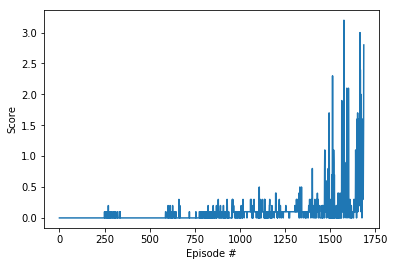

In [8]:
scores_all = ma_ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_all)), scores_all)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [9]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 